In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (20.0, 10.0) # set default size of plots

In [2]:
def fullseed(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True


In [3]:
seed = 1344
fullseed(seed)

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

In [4]:
# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# !unzip hymenoptera_data.zip

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=x=="train", num_workers=4, worker_init_fn=fullseed(seed))
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



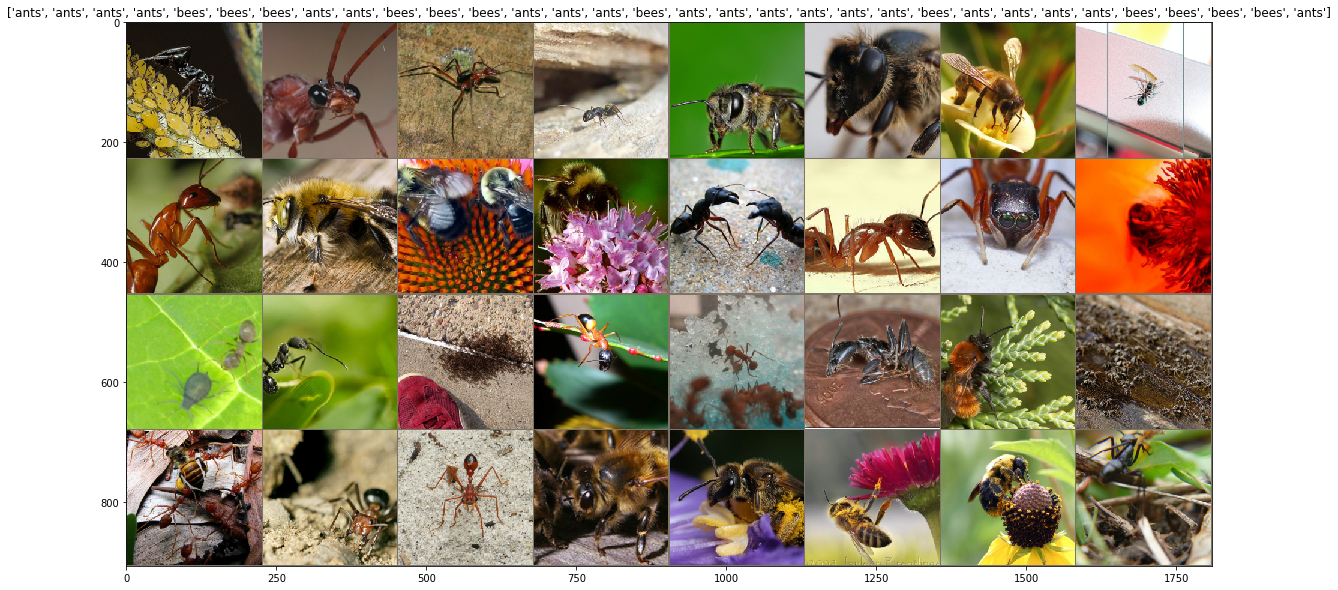

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model

In [7]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    lrs = []
    losses = {"train": [], "val": []}
    metrics = {"train": [], "val": []}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                lrs.append(optimizer.param_groups[0]['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                if scheduler:
                    scheduler.step()
                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            metrics[phase].append(epoch_acc.detach().cpu().numpy())
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    fig, axs = plt.subplots(1, 3)
    
    
    axs[0].plot(range(num_epochs), lrs)
    axs[0].legend(["lr"])
    
    
    for phase in ['train', 'val']:
        axs[1].plot(range(num_epochs), losses[phase])
    axs[1].legend(["train loss", "val loss"])
    
    for phase in ['train', 'val']:
        axs[2].plot(range(num_epochs), metrics[phase])
    axs[2].legend(["train acc", "val acc"])
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




Epoch 0/9
----------
train Loss: 0.6423 Acc: 0.6352
val Loss: 0.4840 Acc: 0.8366

Epoch 1/9
----------
train Loss: 0.3809 Acc: 0.8893
val Loss: 0.3158 Acc: 0.9216

Epoch 2/9
----------
train Loss: 0.2311 Acc: 0.9385
val Loss: 0.2369 Acc: 0.9346

Epoch 3/9
----------
train Loss: 0.1474 Acc: 0.9713
val Loss: 0.2003 Acc: 0.9346

Epoch 4/9
----------
train Loss: 0.0859 Acc: 0.9959
val Loss: 0.1905 Acc: 0.9281

Epoch 5/9
----------
train Loss: 0.0650 Acc: 0.9959
val Loss: 0.1795 Acc: 0.9346

Epoch 6/9
----------
train Loss: 0.0733 Acc: 0.9836
val Loss: 0.1737 Acc: 0.9281

Epoch 7/9
----------
train Loss: 0.0507 Acc: 1.0000
val Loss: 0.1711 Acc: 0.9346

Epoch 8/9
----------
train Loss: 0.0281 Acc: 1.0000
val Loss: 0.1697 Acc: 0.9412

Epoch 9/9
----------
train Loss: 0.0269 Acc: 1.0000
val Loss: 0.1714 Acc: 0.9412

Training complete in 0m 16s
Best val Acc: 0.941176


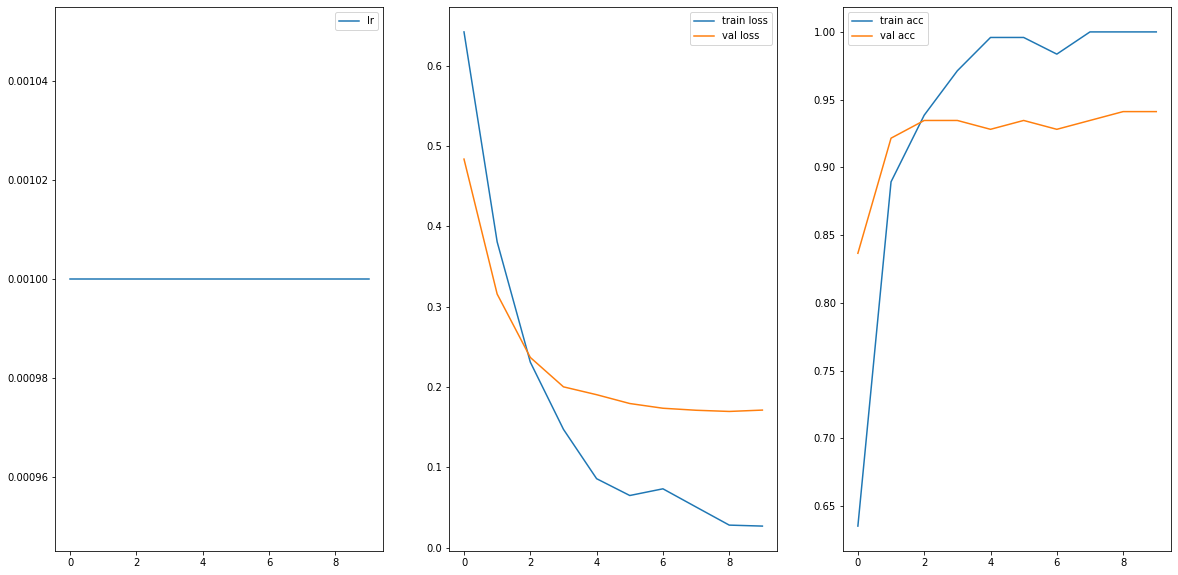

In [9]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = None

model_ft = train_model(model, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=10)

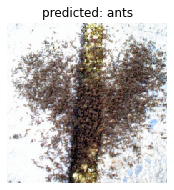

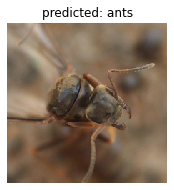

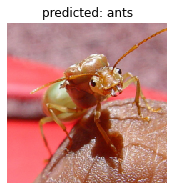

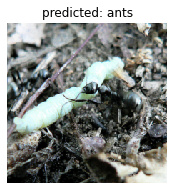

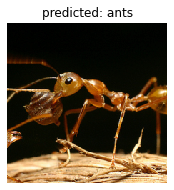

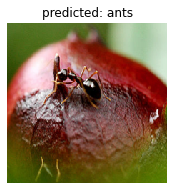

In [10]:
visualize_model(model_ft)

# Add augmentations

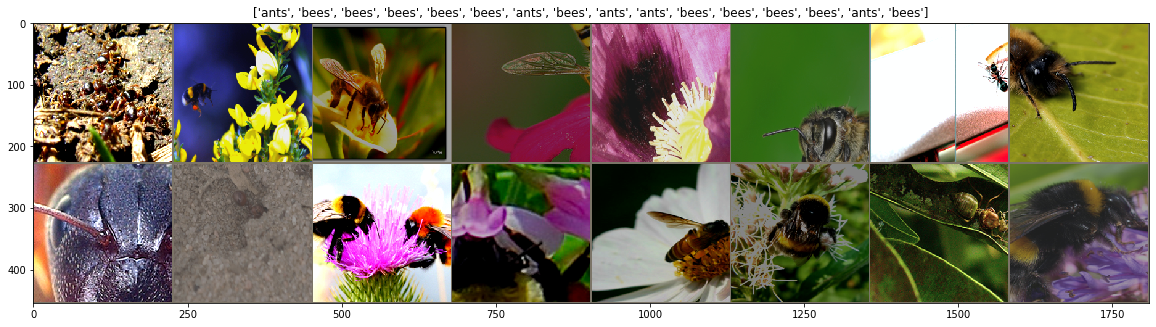

In [27]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Epoch 0/9
----------
train Loss: 0.6385 Acc: 0.6844
val Loss: 0.3104 Acc: 0.9216

Epoch 1/9
----------
train Loss: 0.3502 Acc: 0.8484
val Loss: 0.1906 Acc: 0.9477

Epoch 2/9
----------
train Loss: 0.2812 Acc: 0.8934
val Loss: 0.1734 Acc: 0.9542

Epoch 3/9
----------
train Loss: 0.2048 Acc: 0.9180
val Loss: 0.1421 Acc: 0.9477

Epoch 4/9
----------
train Loss: 0.2573 Acc: 0.8811
val Loss: 0.1634 Acc: 0.9216

Epoch 5/9
----------
train Loss: 0.2135 Acc: 0.9016
val Loss: 0.2001 Acc: 0.9542

Epoch 6/9
----------
train Loss: 0.2246 Acc: 0.8975
val Loss: 0.1670 Acc: 0.9412

Epoch 7/9
----------
train Loss: 0.1641 Acc: 0.9385
val Loss: 0.1687 Acc: 0.9346

Epoch 8/9
----------
train Loss: 0.1299 Acc: 0.9549
val Loss: 0.1637 Acc: 0.9412

Epoch 9/9
----------
train Loss: 0.1658 Acc: 0.9262
val Loss: 0.2088 Acc: 0.9216

Training complete in 0m 16s
Best val Acc: 0.954248


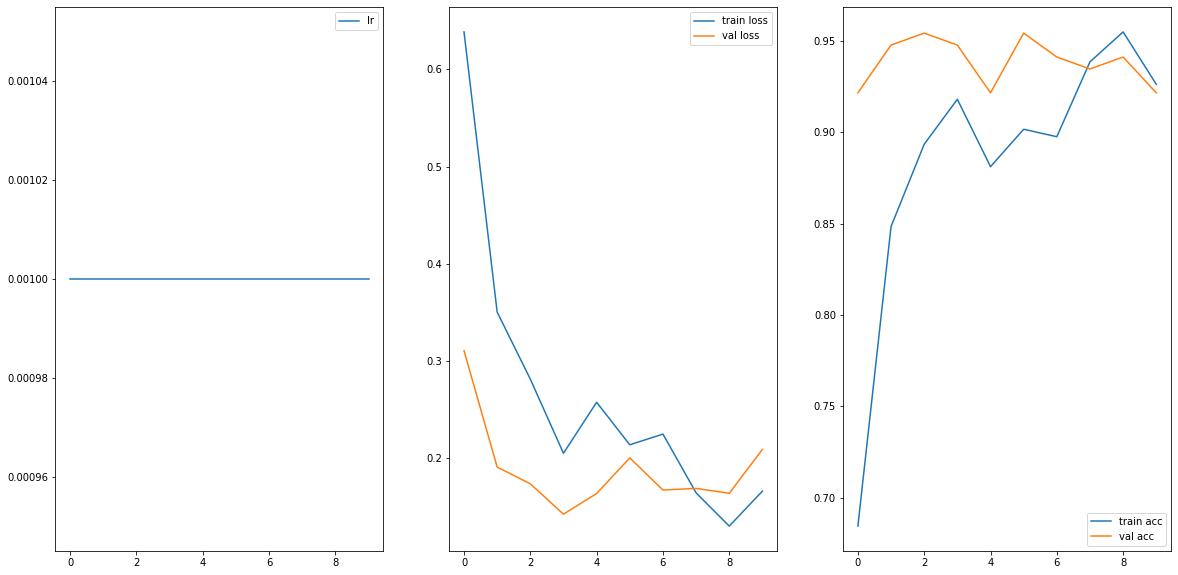

In [31]:
model2 = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model2.fc = nn.Linear(num_ftrs, len(class_names))

model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=1e-3, momentum=0.9)
scheduler = None

model_ft2 = train_model(model2, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=10)

# Add scheduling

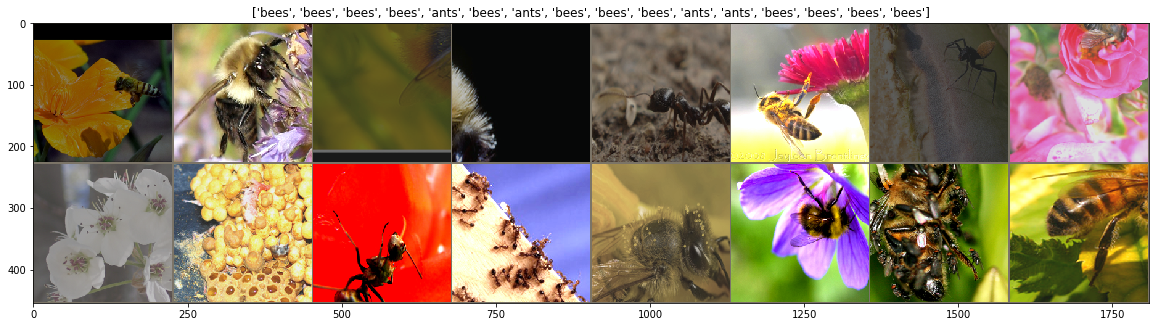

In [29]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Epoch 0/14
----------
train Loss: 0.6509 Acc: 0.6516
val Loss: 0.3117 Acc: 0.9150

Epoch 1/14
----------
train Loss: 0.3208 Acc: 0.8689
val Loss: 0.2241 Acc: 0.9281

Epoch 2/14
----------
train Loss: 0.3070 Acc: 0.8566
val Loss: 0.1669 Acc: 0.9346

Epoch 3/14
----------
train Loss: 0.2005 Acc: 0.9098
val Loss: 0.1505 Acc: 0.9477

Epoch 4/14
----------
train Loss: 0.2654 Acc: 0.8770
val Loss: 0.1570 Acc: 0.9412

Epoch 5/14
----------
train Loss: 0.2314 Acc: 0.9098
val Loss: 0.1696 Acc: 0.9346

Epoch 6/14
----------
train Loss: 0.1615 Acc: 0.9344
val Loss: 0.1505 Acc: 0.9608

Epoch 7/14
----------
train Loss: 0.1800 Acc: 0.9221
val Loss: 0.1534 Acc: 0.9477

Epoch 8/14
----------
train Loss: 0.2019 Acc: 0.9262
val Loss: 0.1544 Acc: 0.9542

Epoch 9/14
----------
train Loss: 0.1530 Acc: 0.9508
val Loss: 0.1525 Acc: 0.9542

Epoch 10/14
----------
train Loss: 0.1701 Acc: 0.9344
val Loss: 0.1526 Acc: 0.9477

Epoch 11/14
----------
train Loss: 0.1339 Acc: 0.9549
val Loss: 0.1535 Acc: 0.9542

Ep

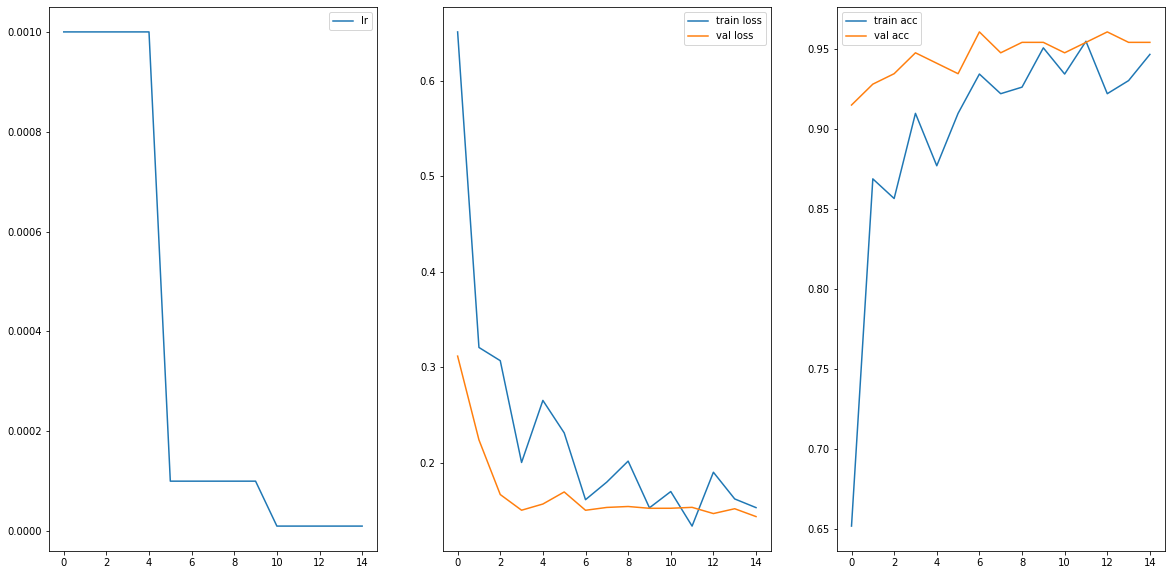

In [32]:
model3 = models.resnet18(pretrained=True)
num_ftrs = model3.fc.in_features
model3.fc = nn.Linear(num_ftrs, len(class_names))

model3 = model3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5)

model_ft3 = train_model(model3, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=15)

# Homework:  transfer learning instead of finetuning and compare results

## Hint
You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.